# 加速度、角速度数据以及位置、速度、姿态标准值生成

## BNO055的技术规格

BNO055的[数据手册](./docs/datasheets/bst-bno055-ds000.pdf)

### **1. 集成特性**

- **传感器类型**：
    - **加速度计**：14 位，量程 ±2g/±4g/±8g/±16g
    - **陀螺仪**：16 位，量程 ±125°/s 至 ±2000°/s
    - **磁力计**：分辨率约 0.3µT，量程 ±1300µT（x、y 轴），±2500µT（z 轴）
- **数据输出**：四元数（Quaternion）、欧拉角、旋转矢量、线性加速度、重力、航向角

---

### **2. 尺寸与封装**

- **尺寸**：3.8 x 5.2 x 1.1 mm³
- **封装类型**：LGA，28 引脚

---

### **3. 功耗与电源**

- **电压范围**：
    - VDD：2.4V - 3.6V
    - VDDIO：1.7V - 3.6V
- **电源模式**：
    - 正常模式（Normal）
    - 低功耗模式（Low Power）
    - 挂起模式（Suspend）

---

### **4. 环境适应性**

- **工作温度范围**：-40°C 至 +85°C
- **环保认证**：RoHS、无卤素

---

### **5. 接口**

- **数字接口**：
    - I²C（支持 HID-I²C 协议）
    - UART
- **Windows 支持**：兼容 Windows 8.x

---


### **最关键参数总结**

- **加速度计**：±2g 至 ±16g
- **陀螺仪**：±125°/s 至 ±2000°/s
- **磁力计**：±1300µT（x、y 轴），±2500µT（z 轴）
- **电压范围**：VDD 2.4V - 3.6V，VDDIO 1.7V - 3.6V
- **工作温度**：-40°C 至 +85°C

## 定义IMU模型


电子胶囊使用的IMU是中等精度的BNO055，特别适合低功耗和成本敏感的应用。在`gnss-ins-sim`中按如下指标来调整模型


1. **陀螺仪（Gyro）**
   - 零偏（`gyro_b`）：按照 0.5°/hr 转换为每秒单位。
   - 角速度随机游走（`gyro_arw`）：调整为 BNO055 典型值 0.05°/√s。
   - 偏置稳定性（`gyro_b_stability`）：根据实际硬件特性调整到 0.03°/s。
   - 偏置相关性（`gyro_b_corr`）：设为 100 秒，符合典型性能。

2. **加速度计（Accel）**
   - 零偏（`accel_b`）：设为 0.01 m/s²，模拟 ±0.1% 偏差范围。
   - 随机游走（`accel_vrw`）：设为 0.002 m/s/√s，符合实际噪声。
   - 偏置稳定性（`accel_b_stability`）：参考实际加速度计偏置噪声，设为 1e-4 m/s²。
   - 偏置相关性（`accel_b_corr`）：设为 200 秒。

3. **磁力计（Magnetometer）**
   - 噪声标准差（`mag_std`）：设为 0.3 µT，符合 BNO055 的磁力计分辨率。


In [1]:
import os
import math
import numpy as np
from gnss_ins_sim.sim import imu_model
from gnss_ins_sim.sim import ins_sim

# 参考 BNO055 硬件特性设置IMU 模型参数
imu_err = {
    'gyro_b': np.array([0.5, 0.5, 0.5]),         # 陀螺仪零偏，单位：°/s（假设长期偏差约 0.5°/hr 转换为 °/s）
    'gyro_arw': np.array([0.05, 0.05, 0.05]),    # 角速度随机游走，单位：°/√s（根据 BNO055 的典型性能）
    'gyro_b_stability': np.array([0.03, 0.03, 0.03]), # 陀螺仪零偏稳定性，单位：°/s
    'gyro_b_corr': np.array([100.0, 100.0, 100.0]), # 零偏相关时间，单位：s

    'accel_b': np.array([0.01, 0.01, 0.01]),     # 加速度计零偏，单位：m/s²（假设 ±0.1% 的偏差范围）
    'accel_vrw': np.array([0.002, 0.002, 0.002]),# 加速度计速度随机游走，单位：m/s/√s（BNO055 加速度计噪声特性）
    'accel_b_stability': np.array([1e-4, 1e-4, 1e-4]), # 加速度计零偏稳定性，单位：m/s²
    'accel_b_corr': np.array([200.0, 200.0, 200.0]),   # 零偏相关时间，单位：s
}


### 创建IMU对象并生成数据

创建一个IMU对象，然后使用`gnss-ins-sim`生成IMU数据至`datasets/gnss_ins_sim`文件夹下。数据集的motion profile是一个简单的直线运动，包括加速度、角速度和磁力计数据。

```csv
ini lat (deg),ini lon (deg),ini alt (m),ini vx_body (m/s),ini vy_body (m/s),ini vz_body (m/s),ini yaw (deg),ini pitch (deg),ini roll (deg)
0,0,0,0,0.1,0,0,0,0
command type,yaw (deg),pitch (deg),roll (deg),vx_body (m/s),vy_body (m/s),vz_body (m/s),command duration (s),GPS visibility
1,0,0,0,0,0,0,5,1

```

该代码最终生成了一段非常简单的 水平匀速直线轨迹，持续5秒，速度为0.1m/s，IMU从(0.0, 0.0) 到 (0.0, 0.5)

In [ ]:
motion_def_path = os.path.abspath('.//datasets//motion_defs')
raw_data_path = os.path.abspath('.//datasets//gnss_ins_sim//')
results_path = os.path.abspath('.//datasets//datasets//')

fs = 100.0          # IMU sample frequency
duration = 5        # simulation duration(s)
position_start = np.array([0.0, 0.0, 0.0])  # initial position
position_end = np.array([0.5, 0.0, 0.0])    # final position

#### 选择适当的IMU误差模型
imu = imu_model.IMU(accuracy=imu_err, axis=6, gps=True)  # 使用6轴IMU模型，含有加速度计、陀螺仪

#### start simulation
sim = ins_sim.Sim([fs, fs, 0.0],
                      motion_def_path+"//motion_def.csv",
                      ref_frame=1,
                      imu=imu,
                      mode=None,
                      env=None,
                      algorithm=None)
sim.run(1)

# 查看可用数据名称
available_data = sim.get_names_of_available_data()
print("Available Data:", available_data)

# 修改位置初始值为0
ref_pos = sim.get_data(['ref_pos'])[0]
ref_pos -= ref_pos[0]
print("Modified ref_pos:\n", ref_pos[:5])  # 打印前5行修改后的参考位置
# 将修改后的数据写回数据管理器
sim.dmgr.add_data(sim.dmgr.ref_pos.name, ref_pos)

# 保存仿真结果到文件
os.makedirs(raw_data_path, exist_ok=True)
sim.results(raw_data_path)


# 可视化仿真数据：绘制陀螺仪、加速度计和参考位置数据
sim.plot(['gyro', 'accel', 'ref_pos', 'ref_vel', 'ref_att_euler', 'ref_att_quat'], opt={'ref_pos': '3d'})

ValueError: Magnetometer is enabled, but its noise std is not specified.

# 磁场数据生成

![magpylib](./figures/maglib.png)

磁铁的坐标分别为 (0.1, 0, -0.08) 和 (0.4, 0, -0.08)，传感器观察的路径为从 (0, 0, 0) 到 (0.5, 0, 0)。

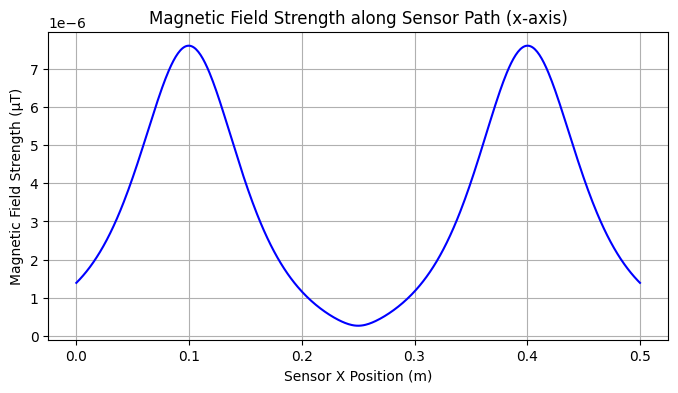

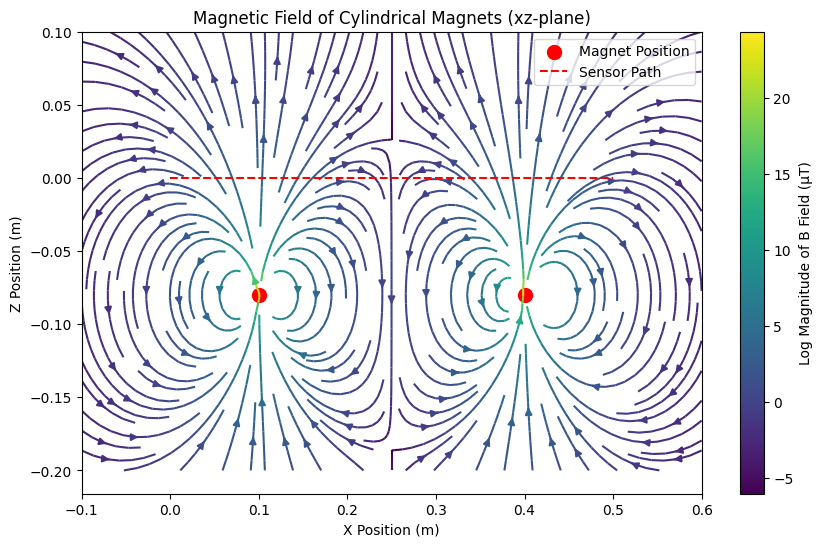

In [48]:
# Importing necessary libraries
import magpylib as magpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters for customization
magnet_positions = [(0.1, 0, -0.08), (0.4, 0, -0.08)]  # Magnet positions in meters
sensor_start = position_start  # Start of sensor path
sensor_end = position_end  # End of sensor path
sensor_resolution = int(fs * duration)  # Number of points along sensor path
magnetization_strength = 1000000  # Magnetization of the magnets in T
magnet_radius = 0.005  # Magnet radius in meters
magnet_height = 0.001  # Magnet height in meters

# Create cylindrical magnets
magnets = [
    magpy.magnet.Cylinder(magnetization=(0, 0, magnetization_strength),
                          dimension=(magnet_radius, magnet_height)).move(pos)
    for pos in magnet_positions
]

# Define sensor positions along the observation path
sensor_positions = np.linspace(sensor_start, sensor_end, sensor_resolution)

# Compute magnetic field at each sensor position and store in a DataFrame
magnetic_data_x = np.zeros(sensor_resolution)
magnetic_data_y = np.zeros(sensor_resolution)
magnetic_data_z = np.zeros(sensor_resolution)
for i, pos in enumerate(sensor_positions):
    total_field = sum(magnet.getB(pos) for magnet in magnets)  # Sum magnetic fields
    magnetic_data_x[i], magnetic_data_y[i], magnetic_data_z[i] = total_field

magnetic_field_strength = np.sqrt(magnetic_data_x**2 + magnetic_data_y**2 + magnetic_data_z**2)

# Extract sensor x-coordinates for plotting
sensor_x_coords = sensor_positions[:, 0]

# Plot magnetic field strength along sensor path
plt.figure(figsize=(8, 4))
plt.plot(sensor_x_coords, magnetic_field_strength, color='blue')
plt.title("Magnetic Field Strength along Sensor Path (x-axis)")
plt.xlabel("Sensor X Position (m)")
plt.ylabel("Magnetic Field Strength (µT)")
plt.grid(True)
plt.show()

# Visualize magnetic field in the xz-plane
x_vals = np.linspace(-0.1, 0.6, 100)  # X-axis range in meters
z_vals = np.linspace(-0.2, 0.1, 100)  # Z-axis range in meters
X, Z = np.meshgrid(x_vals, z_vals)
B_field = np.array([
    [sum(magnet.getB([x, 0, z]) for magnet in magnets) for x in x_vals]
    for z in z_vals
])
Bx, Bz = B_field[:, :, 0] * 1e6, B_field[:, :, 2] * 1e6  # Convert T to µT

# Plot magnetic field vectors
plt.figure(figsize=(10, 6))
plt.streamplot(X, Z, Bx, Bz, color=np.log(Bx**2 + Bz**2), density=1.5, cmap='viridis')
plt.colorbar(label="Log Magnitude of B Field (µT)")

# Draw magnet positions
for pos in magnet_positions:
    plt.scatter(pos[0], pos[2], color='red', s=100, label="Magnet Position" if pos == magnet_positions[0] else "")

# Draw sensor observation line
plt.plot(sensor_x_coords, sensor_start[2] * np.ones_like(sensor_x_coords), 'r--', label="Sensor Path")

plt.title("Magnetic Field of Cylindrical Magnets (xz-plane)")
plt.xlabel("X Position (m)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.show()


## 数据集

从 gnss_ins_sim 生成的所有数据文件以及仿真得到的磁场数据中，提取如下有效的数据，整合到一个csv文件（`datasets/datasets/imu_data.csv`）中。

- `time (sec)`：时间戳
- `accel_x (m/s^2)`, `accel_y (m/s^2)`, `accel_z (m/s^2)`：加速度计数据
- `ref_accel_x (m/s^2)`, `ref_accel_y (m/s^2)`, `ref_accel_z (m/s^2)`：参考加速度计数据
- `gyro_x (rad/s)`, `gyro_y (rad/s)`, `gyro_z (rad/s)`：陀螺仪数据
- `ref_gyro_x (rad/s)`, `ref_gyro_y (rad/s)`, `ref_gyro_z (rad/s)`：参考陀螺仪数据
- `mag_x (uT)`, `mag_y (uT)`, `mag_z (uT)`：磁力计数据

In [49]:
#### 读取仿真数据
import pandas as pd

raw_ref_pos = pd.read_csv(raw_data_path + '//ref_pos.csv')
raw_ref_vel = pd.read_csv(raw_data_path + '//ref_vel.csv')
raw_ref_att_quat = pd.read_csv(raw_data_path + '//ref_att_quat.csv')
raw_ref_att_euler = pd.read_csv(raw_data_path + '//ref_att_euler.csv')
raw_ref_accel = pd.read_csv(raw_data_path + '//ref_accel.csv')
raw_ref_gyro = pd.read_csv(raw_data_path + '//ref_gyro.csv')
raw_accel = pd.read_csv(raw_data_path + '//accel-0.csv')
raw_gyro = pd.read_csv(raw_data_path + '//gyro-0.csv')
raw_time = pd.read_csv(raw_data_path + '//time.csv')

#### 保存仿真数据到文件
os.makedirs(results_path, exist_ok=True)
results = pd.DataFrame({
    'time (sec)':         raw_time['time (sec)'],
    'ref_accel_x (m/s^2)':  raw_ref_accel['ref_accel_x (m/s^2)'],
    'ref_accel_y (m/s^2)':  raw_ref_accel['ref_accel_y (m/s^2)'],
    'ref_accel_z (m/s^2)':  raw_ref_accel['ref_accel_z (m/s^2)'],
    'accel_x (m/s^2)':      raw_accel['accel_x (m/s^2)'],
    'accel_y (m/s^2)':      raw_accel['accel_y (m/s^2)'],
    'accel_z (m/s^2)':      raw_accel['accel_z (m/s^2)'],
    'ref_gyro_x (rad/s)':   np.deg2rad(raw_ref_gyro['ref_gyro_x (deg/s)']),
    'ref_gyro_y (rad/s)':   np.deg2rad(raw_ref_gyro['ref_gyro_y (deg/s)']),
    'ref_gyro_z (rad/s)':   np.deg2rad(raw_ref_gyro['ref_gyro_z (deg/s)']),
    'gyro_x (rad/s)':       np.deg2rad(raw_gyro['gyro_x (deg/s)']),
    'gyro_y (rad/s)':       np.deg2rad(raw_gyro['gyro_y (deg/s)']),
    'gyro_z (rad/s)':       np.deg2rad(raw_gyro['gyro_z (deg/s)']),
    'mag_x (uT)':           magnetic_data_x,
    'mag_y (uT)':           magnetic_data_y,
    'mag_z (uT)':           magnetic_data_z,
    'ref_pos_x (m)':        raw_ref_pos['ref_pos_x (m)'],
    'ref_pos_y (m)':        raw_ref_pos['ref_pos_y (m)'],
    'ref_pos_z (m)':        raw_ref_pos['ref_pos_z (m)'],
    'ref_vel_x (m/s)':      raw_ref_vel['ref_vel_x (m/s)'],
    'ref_vel_y (m/s)':      raw_ref_vel['ref_vel_y (m/s)'],
    'ref_vel_z (m/s)':      raw_ref_vel['ref_vel_z (m/s)'],
    'ref_Yaw (deg)':        raw_ref_att_euler['ref_Yaw (deg)'],
    'ref_Pitch (deg)':      raw_ref_att_euler['ref_Pitch (deg)'],
    'ref_Roll (deg)':       raw_ref_att_euler['ref_Roll (deg)'],
    'q0 ()':                raw_ref_att_quat['q0 ()'],
    'q1':                   raw_ref_att_quat['q1'],
    'q2':                   raw_ref_att_quat['q2'],
    'q3':                   raw_ref_att_quat['q3'],
})

results.to_csv(results_path + '//imu_data.csv', index=False)

# 打印数据集信息：
## 坐标
print("From ({}, {}) to ({}, {})".format(results['ref_pos_x (m)'][0], results['ref_pos_y (m)'][0],
                                            results['ref_pos_x (m)'][results.shape[0]-1], results['ref_pos_y (m)'][results.shape[0]-1]))

From (0.0, 0.0) to (0.0, 0.4990000000000004)


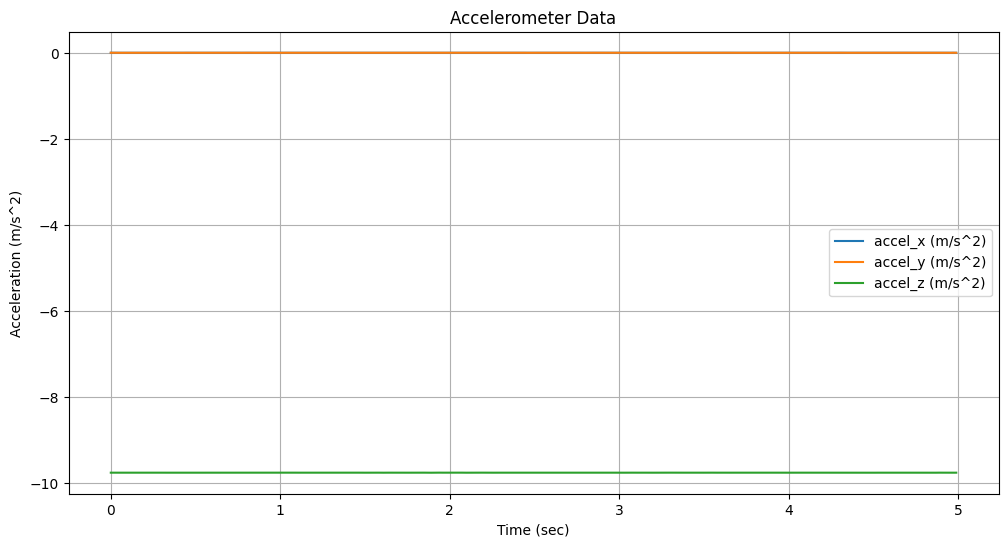

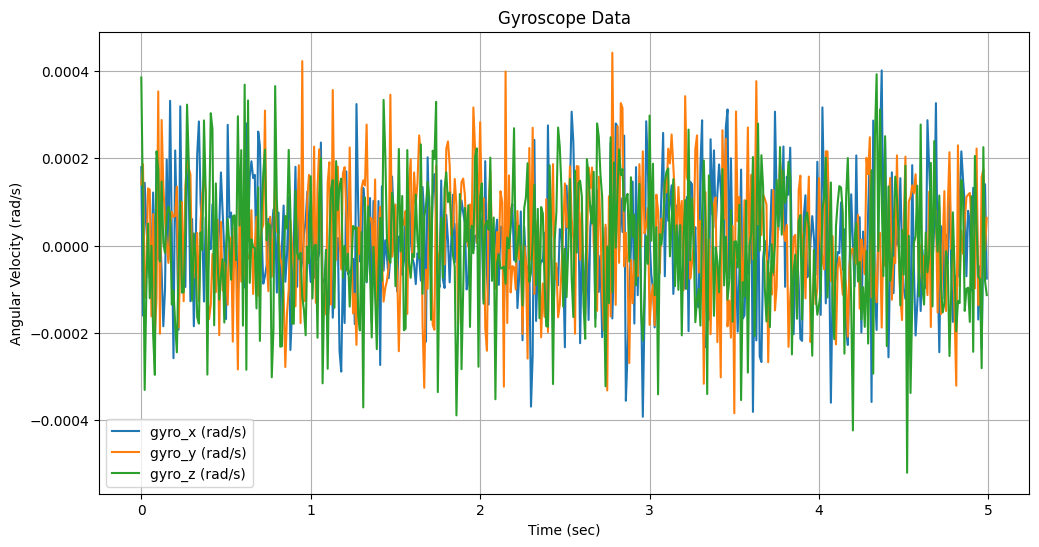

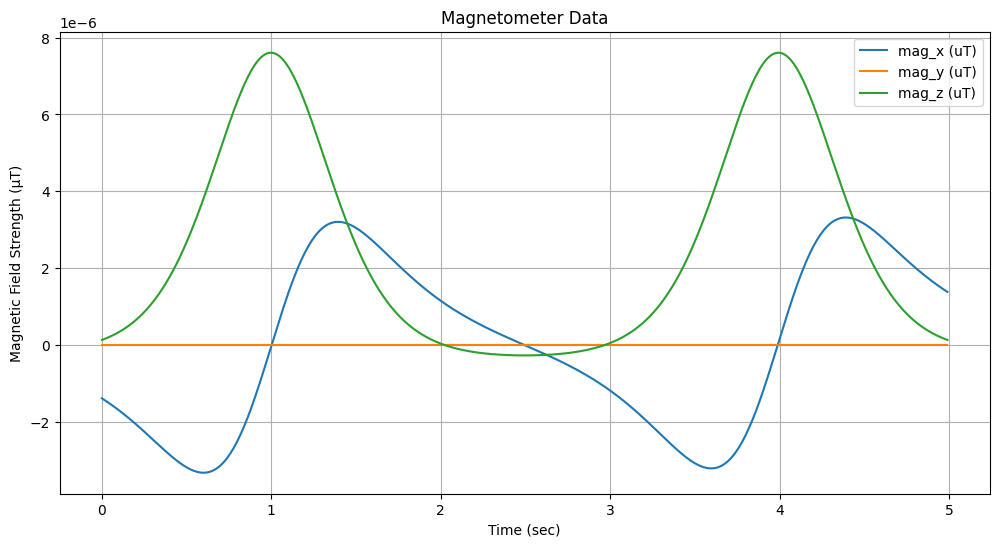

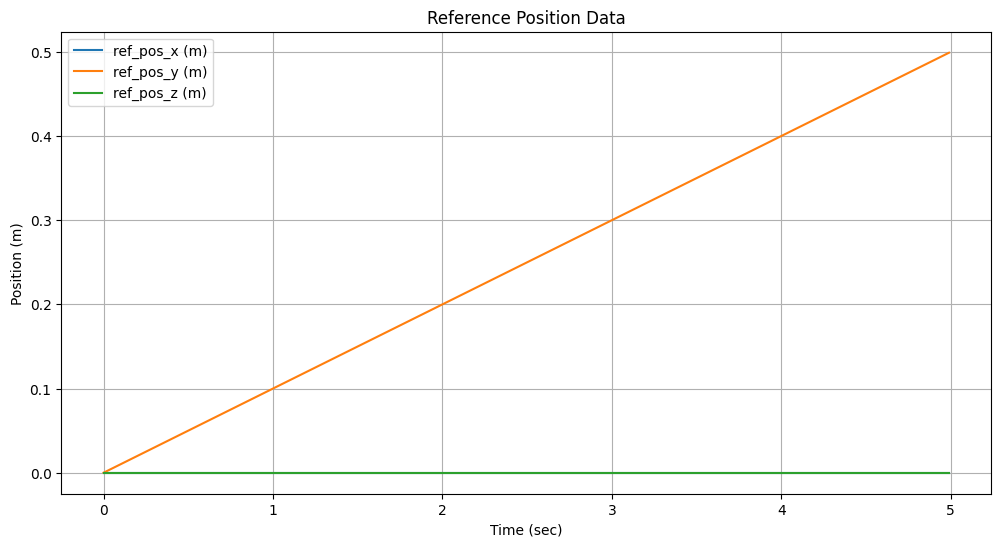

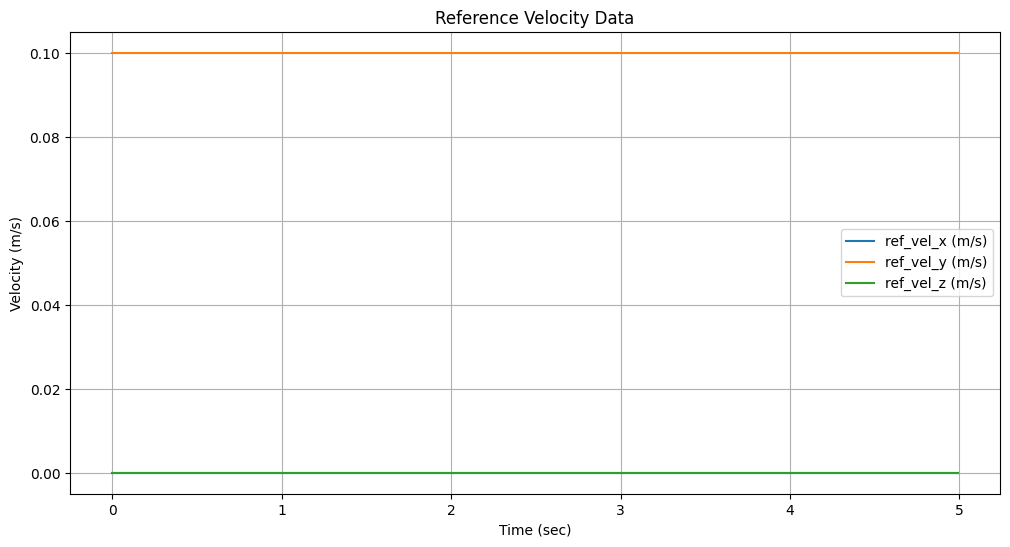

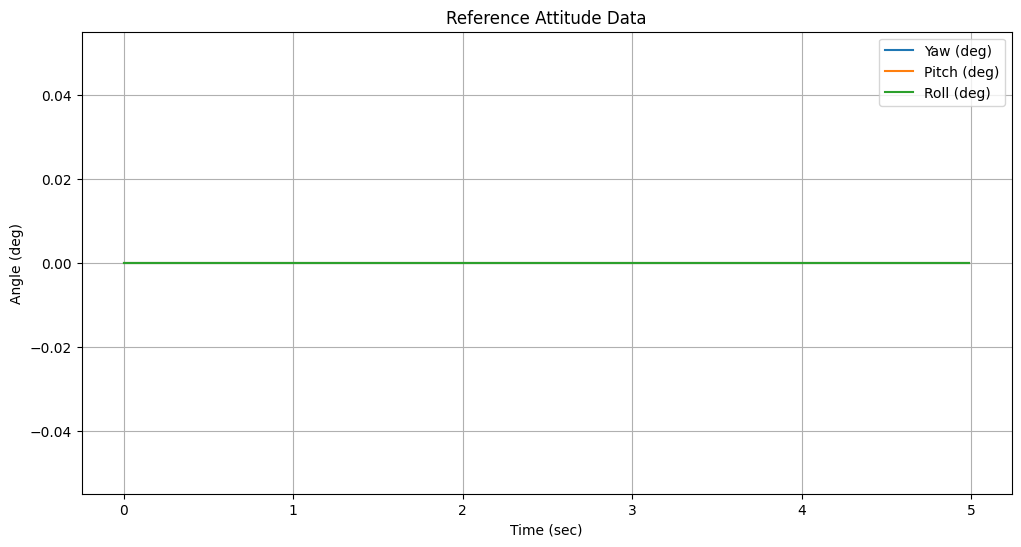

In [52]:
#### 数据集可视化
import matplotlib.pyplot as plt
import pandas as pd


# 绘制加速度计数据
plt.figure(figsize=(12, 6))
plt.plot(results['time (sec)'], results['accel_x (m/s^2)'], label='accel_x (m/s^2)')
plt.plot(results['time (sec)'], results['accel_y (m/s^2)'], label='accel_y (m/s^2)')
plt.plot(results['time (sec)'], results['accel_z (m/s^2)'], label='accel_z (m/s^2)')
plt.title('Accelerometer Data')
plt.xlabel('Time (sec)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

# 绘制陀螺仪数据
plt.figure(figsize=(12, 6))
plt.plot(results['time (sec)'], results['gyro_x (rad/s)'], label='gyro_x (rad/s)')
plt.plot(results['time (sec)'], results['gyro_y (rad/s)'], label='gyro_y (rad/s)')
plt.plot(results['time (sec)'], results['gyro_z (rad/s)'], label='gyro_z (rad/s)')
plt.title('Gyroscope Data')
plt.xlabel('Time (sec)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid(True)
plt.show()

# 绘制磁力计数据
plt.figure(figsize=(12, 6))
plt.plot(results['time (sec)'], results['mag_x (uT)'], label='mag_x (uT)')
plt.plot(results['time (sec)'], results['mag_y (uT)'], label='mag_y (uT)')
plt.plot(results['time (sec)'], results['mag_z (uT)'], label='mag_z (uT)')
plt.title('Magnetometer Data')
plt.xlabel('Time (sec)')
plt.ylabel('Magnetic Field Strength (µT)')
plt.legend()
plt.grid(True)
plt.show()

# 绘制位置数据
plt.figure(figsize=(12, 6))
plt.plot(results['time (sec)'], results['ref_pos_x (m)'], label='ref_pos_x (m)')
plt.plot(results['time (sec)'], results['ref_pos_y (m)'], label='ref_pos_y (m)')
plt.plot(results['time (sec)'], results['ref_pos_z (m)'], label='ref_pos_z (m)')
plt.title('Reference Position Data')
plt.xlabel('Time (sec)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

# 绘制速度数据
plt.figure(figsize=(12, 6))
plt.plot(results['time (sec)'], results['ref_vel_x (m/s)'], label='ref_vel_x (m/s)')
plt.plot(results['time (sec)'], results['ref_vel_y (m/s)'], label='ref_vel_y (m/s)')
plt.plot(results['time (sec)'], results['ref_vel_z (m/s)'], label='ref_vel_z (m/s)')
plt.title('Reference Velocity Data')
plt.xlabel('Time (sec)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# 绘制姿态数据
plt.figure(figsize=(12, 6))
plt.plot(results['time (sec)'], results['ref_Yaw (deg)'], label='Yaw (deg)')
plt.plot(results['time (sec)'], results['ref_Pitch (deg)'], label='Pitch (deg)')
plt.plot(results['time (sec)'], results['ref_Roll (deg)'], label='Roll (deg)')
plt.title('Reference Attitude Data')
plt.xlabel('Time (sec)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.grid(True)
plt.show()

